### FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import R2Y_across_components
from msresist.figures.figure3 import plotR2YQ2Y, plotActualVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.motifs import MapMotifs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [2]:
from sklearn.model_selection import LeaveOneOut
import scipy as sp
from msresist.figures.figure3 import plotActualVsPredicted

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [3]:
X = preprocessing(AXLwt=True, Vfilter=False, FCfilter=False, log2T=True, mc_row=True)

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

treatments = d.index

### Phenotypes

#### Cell Viability:

In [4]:
Y_cv1 = pd.read_csv('./msresist/data/Phenotypic_data/GrowthFactors/CV_raw3.csv').iloc[:30, :11]
Y_cv2 = pd.read_csv('./msresist/data/Phenotypic_data/GrowthFactors/CV_raw4.csv').iloc[:29, :11]

itp = 0
ftp = 72


for ii in range(1, Y_cv2.columns.size):
    Y_cv1.iloc[:, ii] /= Y_cv1.iloc[itp, ii]
    Y_cv2.iloc[:, ii] /= Y_cv2.iloc[itp, ii]

y_ = MergeDfbyMean(pd.concat([Y_cv1, Y_cv2], axis=0), Y_cv1.columns, "Elapsed")
y_ = y_.reset_index()[Y_cv1.columns]
y = pd.DataFrame()
y["Cell Viability"] = y_[y_["Elapsed"] == ftp].iloc[0, 1:]

In [5]:
from scipy.stats import zscore
y.iloc[:, :] = zscore(y.iloc[:, :])
y

,Cell Viability
PC9,2.208011
E,-0.362599
R,-0.262451
ER,-0.981351
EHGF,0.506524
EFGF,1.306331
EIGF,-0.113511
KOE,-0.790817
KOR,-0.423649
KOER,-1.086487


# 1-.Fitting PLSR model to the full data set

#### R2Y/Q2Y

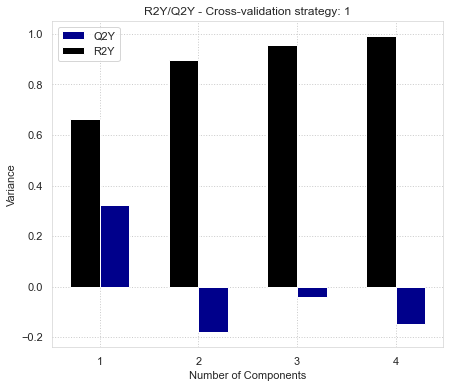

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p1 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax, p1, d, y, 1, 5)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

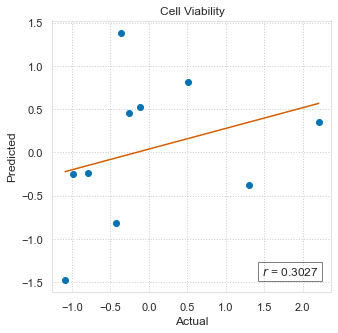

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p1, d, y, cv=1, y_pred="cross-validation")

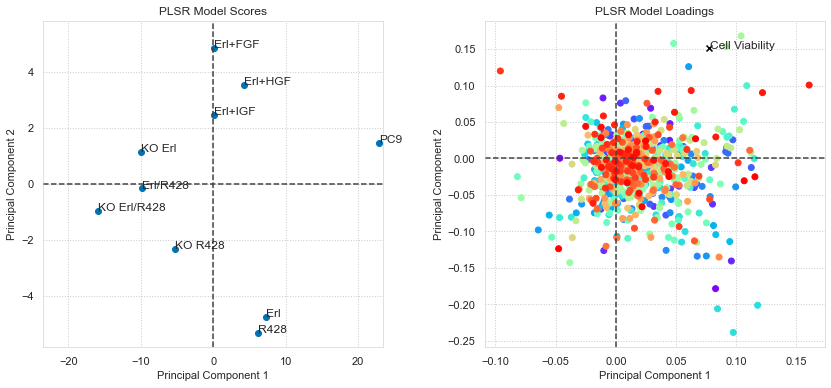

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p1.fit(d, y), d, y, 0, treatments, cv=1, data="full", annotate=False)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

# 2-Clustering and PLSR model

In [9]:
ncl = 9

## 2.1-Standard Clustering methods + PLSR

#### k-means:

In [10]:
from sklearn.cluster import KMeans

labels = KMeans(n_clusters=ncl).fit(d.T).labels_
x_ = X.copy()
x_["Cluster"] = labels
c8 = x_.groupby("Cluster").mean().T

#### SKLEARN's GMM:

In [11]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=ncl, covariance_type='diag').fit(d.T)
# x_ = X.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### POMEGRANATE's GMM:

In [12]:
from pomegranate import GeneralMixtureModel, NormalDistribution

gmm = GeneralMixtureModel.from_samples(NormalDistribution, X=d.T, n_components=ncl)
x_ = X.copy()
x_["Cluster"] = gmm.predict(d.T)
c1 = x_.groupby("Cluster").mean().T

#### R2Y/Q2Y

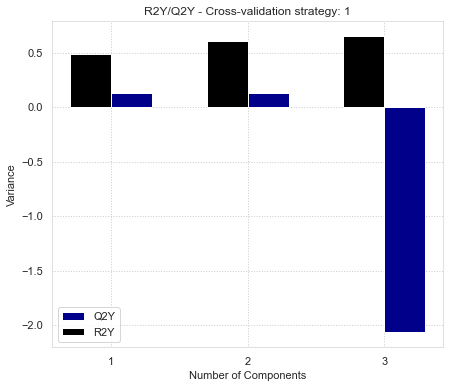

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p2 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax, p2, c1, y, 1, 4)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

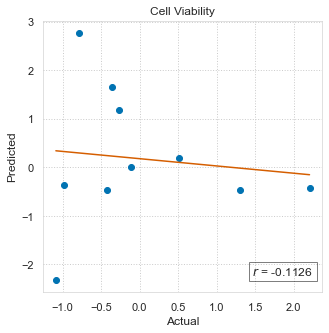

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p2, c1, y, cv=1, y_pred="cross-validation")

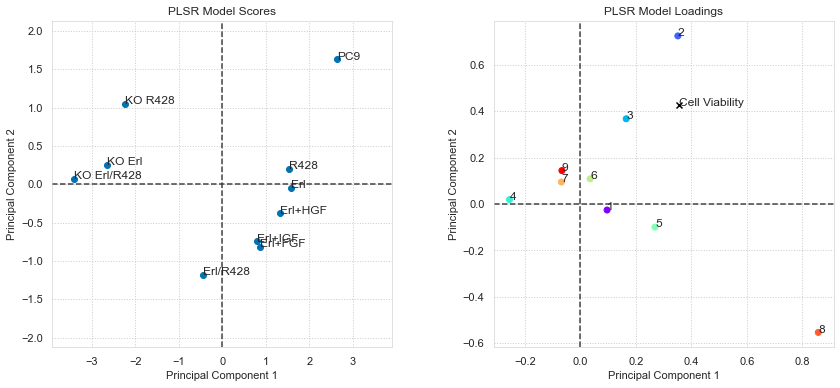

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p2.fit(c1, y), c1, y, ncl, treatments, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

## 2.2-Co-clustering and PLSR

## Cross-validation Strategy 1: Leaving one condition out across fixed clusters

### Fitting PLSR each time

In [16]:
distance_method = "PAM250"
SeqWeight = 0.05

MSC = MassSpecClustering(i, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(d, y)
c2 = MSC.transform(d)

Re-initialize GMM clusters, empty cluster(s) at iteration 1


In [17]:
MSC.wins_

'SeqWins: 187 DataWins: 528 BothWin: 112 MixWin: 44'

#### R2Y/Q2Y

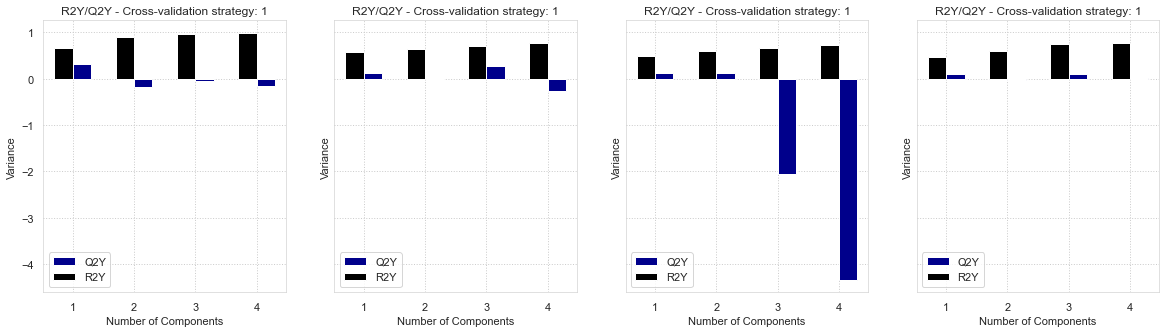

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
p5 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax[0], p5, d, y, 1, 5)

p8 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax[1], p8, c8, y, 1, 5)

p6 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax[2], p6, c1, y, 1, 5)

p10 = PLSRegression(n_components=2, scale=False)
plotR2YQ2Y(ax[3], p10, c2, y, 1, 5)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

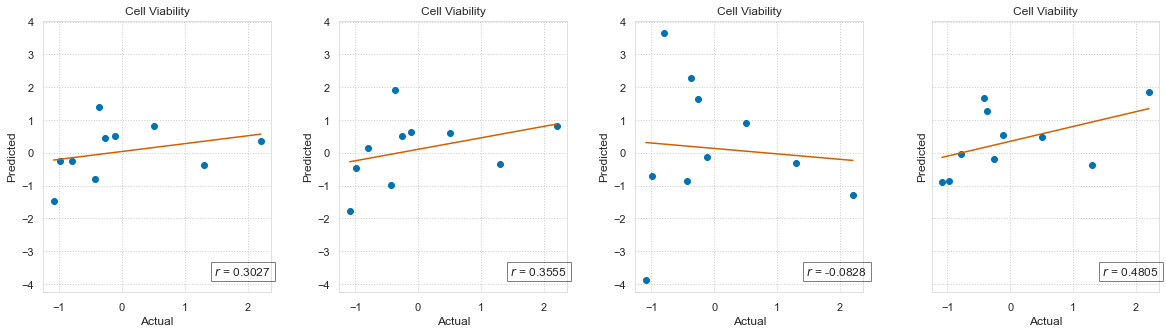

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(axes[0], p5, d, y, cv=1, y_pred="cross-validation")

plotActualVsPredicted(axes[1], p8, c8, y, 1, y_pred="cross-validation")

plotActualVsPredicted(axes[2], p6, c1, y, 1, y_pred="cross-validation")

plotActualVsPredicted(axes[3], p1, c2, y, 1, y_pred="cross-validation")
axes[1].yaxis.set_tick_params(labelleft=True)
axes[2].yaxis.set_tick_params(labelleft=True)
plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Scores & Loadings

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p3.fit(c2, y), c2, y, ncl, treatments, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
raise SystemExit

## 2.3-Random clustering and PLSR

In [ ]:
from random import choices
x__ = X.copy()
x__["Cluster"] = choices(list(np.arange(ncl)), k=X.shape[0])
c3 = x__.groupby("Cluster").mean().T

#### R2Y/Q2Y

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p4 = PLSRegression(n_components=2)
plotR2YQ2Y(ax, p4, c3, y, 1, ncl+1)

#### Predictions

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p4, c3, y, 1, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

## Cross-validation Strategy 2: Across entire pipeline

### Fitting entire model pipeline each time

In [ ]:
ncomp = 2

CoCl_plsr = Pipeline([('CoCl', MassSpecClustering(i, ncl, SeqWeight=SeqWeight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp, scale=False))])
fit = CoCl_plsr.fit(d, y.values)
centers = CoCl_plsr.named_steps.CoCl.transform(d)

#### R2Y/Q2Y

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# plotR2YQ2Y(ax, CoCl_plsr, d, y, cv=2, b=5)

#### GridSearch

Run:

In [ ]:
%%time
scores = MSclusPLSR_tuning(d, i, y, "PAM250")
scores = pd.DataFrame(scores)

In [ ]:
hp = scores.sort_values(by="mean_test_score", ascending=False)
hp.insert(0, "Ranking", list(np.arange(1, hp.shape[0]+1)))

#### Measured vs Predicted

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,4))
plotActualVsPredicted(ax, CoCl_plsr, d, y, 2)

#### Scores & Loadings

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, y, ncl, lines, 2)

In [ ]:
clustermembers = CoCl_plsr.named_steps.CoCl.clustermembers(X.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")